In [1]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
import json
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
#from emoji_unicode import UNICODE_EMO
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
import string, re
from textblob_nl.nl import sentiment as pattern_sentiment
from textblob.classifiers import NaiveBayesClassifier
pd.set_option('max_colwidth', 1000)
import seaborn as sns

In [2]:
client = MongoClient('localhost', 27017)
mydb = client.tweet
convos = mydb['convos']
tweets = mydb['_tweets']

In [3]:
air_names = ['@KLM', '@AirFrance', '@British_Airways', '@AmericanAir', '@Lufthansa', '@AirBerlin', '@AirBerlinAssist', '@easyJet', '@RyanAir', '@SingaporeAir', '@Qantas', '@EtihadAirways', '@VirginAtlantic']

In [4]:
airlines = {'KLM':56377143, 
            'AirFrance': 106062176, 
            'British_Airways': 18332190, 
            'AmericanAir': 22536055, 
           'Lufthansa': 124476322, 
           'AirBerlin': 26223583, 
           'AirBerlinAssist': 2182373406, 
           'easyJet': 38676903, 
           'RyanAir': 1542862735, 
           'SingaporeAir': 253340062, 
           'Qantas': 218730857, 
           'EtihadAirways': 45621423, 
           'VirginAtlantic': 20626359}

* Created a dataframe which includes tweets in english to the airlines, along with the tweet id, user id and timestamp.

In [30]:
jdf = pd.DataFrame()
jdf['tweet'] = [t['text'] for t in tweets.find({}) for n in air_names if n in t['text'] if t['language']=='eng']
jdf['id'] = [t['id'] for t in tweets.find({}) for n in air_names if n in t['text'] if t['language']=='eng']
jdf['user_id'] = [t['user']['id'] for t in tweets.find({}) for n in air_names if n in t['text'] if t['language']=='eng']
jdf['timestamp'] = [t['timestamp_ms'] for t in tweets.find({}) for n in air_names if n in t['text'] if t['language']=='eng']

* Added a new column which states which airline the tweet is referring to.

In [31]:
temp=jdf.tweet.fillna("0")
jdf['airline'] = pd.np.where(temp.str.contains("@KLM"),"KLM",
           pd.np.where(temp.str.contains("@British_Airways"), "British_Airways",
           pd.np.where(temp.str.contains("@easyJet"), "easyJet",
           pd.np.where(temp.str.contains("@AmericanAir"), "AmericanAir",
           pd.np.where(temp.str.contains("@Lufthansa"), "Lufthansa",
           pd.np.where(temp.str.contains("@RyanAir"), "RyanAir",
           pd.np.where(temp.str.contains("@AirBerlin"), "AirBerlin",
           pd.np.where(temp.str.contains("@AirBerlinAssist"), "AirBerlinAssist",
           pd.np.where(temp.str.contains("@AirFrance"), "AirFrance",
           pd.np.where(temp.str.contains("@SingaporeAir"),"SingaporeAir",
           pd.np.where(temp.str.contains("@Qantas"), "Qantas",
           pd.np.where(temp.str.contains("@EtihadAirways"), "EtihadAirways",
           pd.np.where(temp.str.contains("@VirginAtlantic"), "VirginAtlantic", "na")))))))))))))

C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """
C:\Users\jonal\Anacondaa\lib\site-packages\ipykernel_launcher.py:

In [32]:
jdf.head()

,tweet,id,user_id,timestamp,airline
0,@easyJet It is impossible to get in contact with you by using that e-mail address. So there is no claim yet which I can follow on that damage luggage website. So what to do?,1131173038194606100,19610469,1558527643141,easyJet
1,Do you remember when you joined Twitter? I do! #MyTwitterAnniversary Meh. Sure let’s fly Full throttle into this Jovian Sh*tstorm. @NasaJuno #JunoMission @KLM #Wintje https://t.co/2PaxhMimlu,1131173692086599700,728236673037914100,1558527799041,KLM
2,"@AmericanAir flight delays this morning due to mechanical problems. A hassle, but glad to be on the ground while they fix the problems. #beingproductive",1131174000695160800,204548115,1558527872619,AmericanAir
3,"@AmericanAir started out being charged for my luggage when I used my AAdvantage card so it should have been free. Now in Philly, only to find the plane needs a 4 hour repair. Mysteriously now they say 2 hours. Closing my account and won't be flying AA again",1131174316014489600,39829618,1558527947797,AmericanAir
4,"So @AmericanAir @EWRairport lied to an old lady causing her to miss her flight #934 to LHR. She arrived at 6:05am for a flight departing at 8:30am,mum has no medication,is in a wheelchair and they just ignore the fact they caused this.Worse airline company. Zero customer service",1131173065122078700,2730172562,1558527649561,AmericanAir


* Created a function which cleans the text by removing links, hashtags, @mentions and other redundant things to make the sentiment analysis easier. And then applied it do the tweets in the dataframe.

In [33]:
def cleantxt(text):
    text = text.lower()
    text = re.sub('airline', '', text)
    text = re.sub('please', '', text)
    text = re.sub('travel', '', text)
    text = re.sub('airways', '', text)
    text = re.sub('amp', '', text)
    text = re.sub('amsterdam', '', text)
    text = re.sub('singapore', '', text)
    text = re.sub('people', '', text)
    text = re.sub('flight', '', text)
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'https?:\/\/\S+', '', text) 
    text = re.sub(r'RT[\s]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    #for emot in UNICODE_EMO:
    #    text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text

In [34]:
jdf['tweet'] = jdf['tweet'].apply(cleantxt)
jdf[['tweet']]

,tweet
0,it is impossible to get in contact with you by using that email address so there is no claim yet which i can follow on that damage luggage website so what to do
1,do you remember when you joined twitter i do meh sure let’s fly full throttle into this jovian shtstorm
2,delays this morning due to mechanical problems a hassle but glad to be on the ground while they fix the problems
3,started out being charged for my luggage when i used my aadvantage card so it should have been free now in philly only to find the plane needs a hour repair mysteriously now they say hours closing my account and wont be flying aa again
4,so lied to an old lady causing her to miss her to lhr she arrived at for a departing at has no medicationis in a wheelchair and they just ignore the fact they caused thisworse company zero customer service
...,...
736815,trying to get a hold of a customer service person to talk through options for my upcoming due to but every time i call theres not even an option to hold or receive a call back it just hangs up help
736816,it’s a total nightmare i’ve just seen that ny has declared a state emergency so i’m hoping our bookings will be cancelled and refunded or we can change the dates 🤞🏼😩
736817,my mother is due to she is years old with a pacemaker i find it really very hard to believe ba would not give her a credit note given the global health warnings poor lady is equally depressed about losing money as getting ill have a heart ba
736818,absent fever and risk factors attendants as screeners come on mike your playing advocatus diaboli to a nonsensical extreme


* Getting most common words and removing them because not much value

In [35]:
from collections import Counter
cnt = Counter()
for text in jdf["tweet"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('to', 950036),
 ('the', 791394),
 ('and', 513490),
 ('a', 506326),
 ('i', 466898),
 ('you', 368348),
 ('for', 349753),
 ('on', 309170),
 ('in', 303023),
 ('of', 296865),
 ('is', 285683),
 ('my', 268935),
 ('have', 200113),
 ('with', 199548),
 ('it', 192244),
 ('this', 188206),
 ('that', 178468),
 ('your', 168172),
 ('not', 162926),
 ('are', 153902)]

In [36]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(16)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

jdf['tweet'] = jdf['tweet'].apply(remove_freqwords)
jdf[['tweet']].head()

,tweet
0,impossible get contact by using that email address so there no claim yet which can follow that damage luggage website so what do
1,do remember when joined twitter do meh sure let’s fly full throttle into jovian shtstorm
2,delays morning due mechanical problems hassle but glad be ground while they fix problems
3,started out being charged luggage when used aadvantage card so should been free now philly only find plane needs hour repair mysteriously now they say hours closing account wont be flying aa again
4,so lied an old lady causing her miss her lhr she arrived at departing at has no medicationis wheelchair they just ignore fact they caused thisworse company zero customer service


* Training a classifier which then classifies each tweet into a positive one or negative.

In [37]:
train = [
    ('i wish the food service was better', 'neg'),
    ('Great costumer service!', 'pos'),
    ('I am happy with the flight and service', 'pos'),
    ('glad I chose this airline', 'pos'),
    ('fucking costumer service is so bad', 'neg'),
    ('The flight was late, I am not happy with this', 'neg'),
    ('I will never fly with this airline again', 'neg'),
    ('Airline sucks at organization, total nightmare', 'neg'),
    ('Staff was very helpful, very nice', 'pos'),
    ('great to see such developments!', 'pos'),
    ('Today was my last trip outside schengen with klm / amsterdam is the worst airport for international connecting flights', 'neg'),
    ('I like flying with this airline!', 'pos'),
    ('its not helping me at all. Companies too big to solve real problems', 'neg'),
    ('your staff seemingly unaware', 'neg'),
    ('Thank you. But thats not enough. If my flight is delayed more than 3 hours, you must advise Im entitled to assistance AND compensation. Not just say download the brochure.', 'neg'),
    ('worst experience in my life,', 'neg'),
    ('last minute flight cancellation, very dissapointed', 'neg'),
    ('great job at cancelling our flight again!', 'neg'), #sarcasm
    ('you have truly excelled yourself in providing the worst customer service ever', 'neg'), #sarcasm
    ('the food on this airplane was delicious', 'pos'),
    ('delighted with the costumer service here', 'pos'),
    ('the money was refunded quite fast, thanks', 'pos'),
    ('i lost my bag/luggage, but the flight attendants helped me, thank you', 'pos'),
    ('i was disappointed because noone helped me find my luggage/bag', 'neg'),
    ('the flight was very pleasant and fast', 'pos'),
    ('very slow check-in', 'neg'),
    ('the food was bad, maybe u should fix that', 'neg'),
    ('im trying reserve seat upcoming every time give technical error site invite contact resolve help please', 'neg'),
    ('very uncomfortable seats, my back hurts', 'neg'),
    ('the flight was delayed AGAIN, so typical of them', 'neg'),
    ('great work take a suit carrier off me and then have me waste a full hour waiting on your incompetent services', 'neg')
]

test = [
    ('I wish the food on the plane was better, disgusting', 'neg'),
    ('the check-in was very slow', 'neg'),
    ('i wish the check in was faster', 'neg'),
    ('delightful with the costumer service!', 'pos'),
    ('the flight was fast and steady', 'pos'),
    ('fucking costumer service sucks', 'neg'),
    ('it took so long to get my money refunded, maybe you can fix that', 'neg'),
    ('good job at cancelling the flight', 'neg'), #sarcasm
    ('no one from this agency helped me find my bag', 'neg'),
    ('flight attendant helped me with finding my bag, thank you', 'pos'),
    ('helpful staff, glad i chose this airline', 'pos'),
    ('im having technical issues in the site, help please', 'neg'),
    ('me and my family are happy with your service', 'pos'),
    ('the seats were very uncomfortable,', 'neg'),
    ('no space for my legs','neg'),
    ('2/10 experience, people were treated badly', 'neg'),
    ('your reply didnt help me at all', 'neg'),
    ('thank you for replying, that helped a lot', 'pos'),
    ('i hope you actually reply to me this time, i have a big problem', 'neg')
]

cl = NaiveBayesClassifier(train)
cl.accuracy(test)

0.8947368421052632

* Created a function based on the classifier, and applied it to the tweets.

In [38]:
def classify(text):
    prob_dist = cl.prob_classify(text)
    return prob_dist.max()

In [39]:
jdf['class'] = jdf['tweet'].apply(classify)

In [16]:
jdf.head()

,tweet,id,user_id,timestamp,airline,class
0,impossible get contact by using that email address so there no claim yet which can follow that damage luggage website so what do,1131173038194606100,19610469,1558527643141,easyJet,neg
1,do remember when joined twitter do meh sure let’s fly full throttle into jovian shtstorm,1131173692086599700,728236673037914100,1558527799041,KLM,neg
2,delays morning due mechanical problems hassle but glad be ground while they fix problems,1131174000695160800,204548115,1558527872619,AmericanAir,pos
3,started out being charged luggage when used aadvantage card so should been free philly only find plane s hour repair mysteriously they hours closing account wont be flying aa again,1131174316014489600,39829618,1558527947797,AmericanAir,neg
4,so lied an old lady causing her miss her lhr she arrived at departing at has no medicationis wheelchair they ignore fact they caused thisworse company zero customer service,1131173065122078700,2730172562,1558527649561,AmericanAir,neg


In [17]:
jdf['class'].value_counts()

neg    611127
pos    125693
Name: class, dtype: int64

In [18]:
jdf['airline'].value_counts()

AmericanAir        259106
British_Airways    200517
easyJet            102991
KLM                 46782
Qantas              44506
VirginAtlantic      42709
SingaporeAir        18694
EtihadAirways       12667
Lufthansa            5230
AirFrance            3457
RyanAir               160
AirBerlin               1
Name: airline, dtype: int64

* Visualization of most used words from the tweets split into negative and positive.

In [ ]:
negdf = jdf[jdf['class']=='neg']
negwords = ''.join([t for t in negdf['tweet']])
 
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300
                     ).generate(negwords)
plt.figure(1,figsize=(7, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most used words in the negative class')
plt.show()

In [ ]:
posdf = jdf[jdf['class']=='pos']
poswords = ''.join([t for t in posdf['tweet']])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300
                     ).generate(poswords)
plt.figure(1,figsize=(7, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most used words in the positive class')
plt.show()

* Negative words used when tweeting KLM

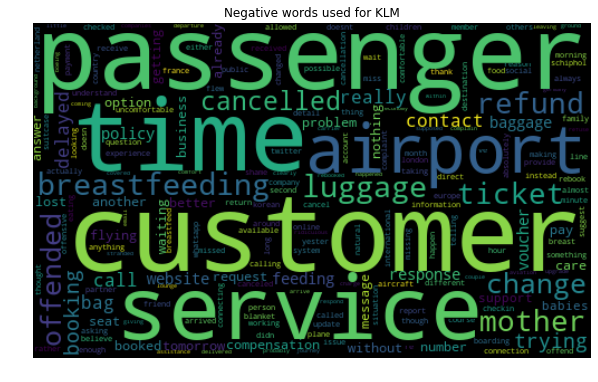

In [19]:
knegdf = jdf[jdf['class']=='neg']
klmneg = knegdf[knegdf['airline']=='KLM']
klmnegwords = ''.join([t for t in klmneg['tweet'] ])
wlst = ['food', 'time', 'hour', 'wait', 'miss', 'suck','fuck','shit','seat','loud','fix','line','lost','lose','bag','talk','flew','call','fast','slow','pay'
       ,'long','care','shame','']

finalst = [w for w in klmnegwords.split() if len(w)>5 or w in wlst]
finafina = ' '.join([w for w in finalst])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300,
                      collocations=False
                     ).generate(finafina)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative words used for KLM')
plt.show()

In [ ]:
for t in klmneg['tweet']:
    if 'breastfeeding' in t :
        print(t)

Top 15 most used words in the negative tweets sent to KLM 

In [20]:
cnt = Counter()
for w in finalst:
    if w not in STOPWORDS:
        cnt[w] += 1
        
cnt.most_common(15)

[('time', 2532),
 ('service', 2130),
 ('airport', 2124),
 ('breastfeeding', 2077),
 ('customer', 2052),
 ('luggage', 2005),
 ('passengers', 1951),
 ('cancelled', 1685),
 ('offended', 1630),
 ('refund', 1621),
 ('change', 1583),
 ('trying', 1496),
 ('ticket', 1414),
 ('booking', 1385),
 ('mother', 1204)]

* Negative words used for Singapore Air

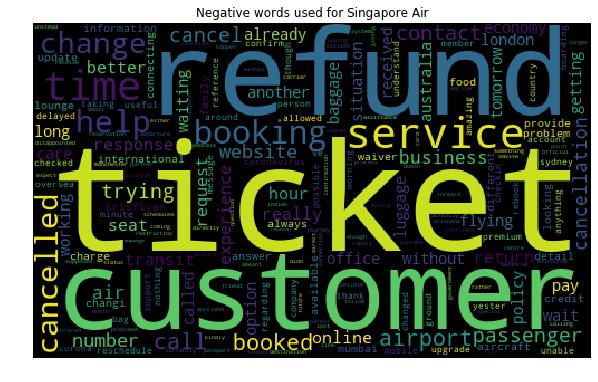

In [21]:
snegdf = jdf[jdf['class']=='neg']
sneg = snegdf[snegdf['airline']=='SingaporeAir']
snegwords = ''.join([t for t in sneg['tweet']])
wlst = ['food', 'time', 'hour', 'wait', 'miss', 'suck','fuck','shit','seat','loud', 'card','air','help','fix','card','line','need','lost','lose','bag','talk','flew','call','fast','slow','pay'
       ,'long','care','shame']

finalst = [w for w in snegwords.split() if len(w)>5 or w in wlst]
finafina = ' '.join([w for w in finalst])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300,
                      collocations=False
                     ).generate(finafina)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Negative words used for Singapore Air')
plt.show()

Top 15 most used words in the negative tweets sent to Singapore Air

In [22]:
cnt = Counter()
for w in finalst:
    if w not in STOPWORDS:
        cnt[w] += 1
        
cnt.most_common(15)

[('refund', 1266),
 ('time', 1072),
 ('booking', 970),
 ('service', 968),
 ('help', 964),
 ('ticket', 924),
 ('customer', 909),
 ('cancelled', 873),
 ('change', 768),
 ('call', 754),
 ('booked', 752),
 ('airport', 689),
 ('contact', 637),
 ('trying', 602),
 ('cancel', 570)]

In [ ]:
kposdf = jdf[jdf['class']=='pos']
klmpos = kposdf[kposdf['airline']=='KLM']
klmposwords = ''.join([t for t in klmpos['tweet']])
nowlst = ['will','make','new','day','see','need','still','im','india','even','wa','ha','via','got','take','uk','dont','want',
        'think','from','us','any','don']
pfinalst = [w for w in klmposwords.split() if len(w)>5 or if w not in nowlst]

pfinafina = ' '.join([w for w in pfinalst])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=500,
                      height=300
                     ).generate(pfinafina)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive words used for KLM')
plt.show()

* Some visualized comparisons between airlines.

Number received tweets per airline

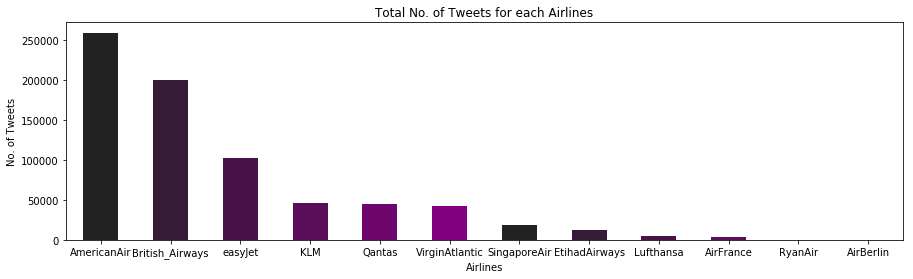

In [23]:
colors=sns.dark_palette("purple") 
pd.Series(jdf["airline"]).value_counts().plot(kind = "bar",
                        color=colors,figsize=(15,4),fontsize=10,rot = 0, title = "Total No. of Tweets for each Airlines")
plt.xlabel('Airlines', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10);

Number of positive and negative tweets per airline

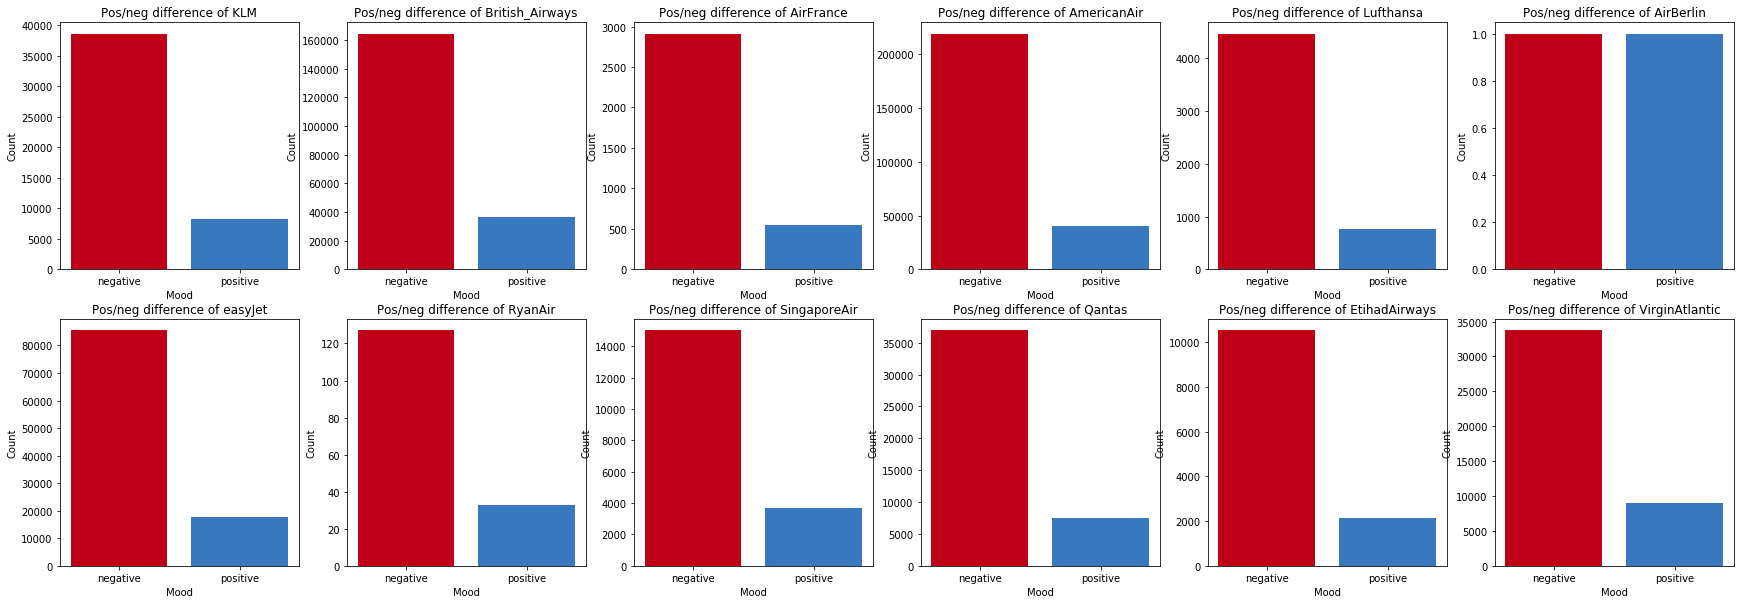

In [24]:
#there was nothing for airberlinassist so i just removed it to make the visualization better
air_names2 = ['KLM', 'British_Airways', 'AirFrance', 'AmericanAir', 'Lufthansa', 'AirBerlin', 'easyJet', 'RyanAir', 'SingaporeAir', 'Qantas', 'EtihadAirways', 'VirginAtlantic'] 

plt.figure(1,figsize=(30, 10))

for i in air_names2:
    indices= air_names2.index(i)
    plt.subplot(2, 6, indices+1)
    new_df=jdf[jdf['airline']==i]
    count=new_df['class'].value_counts()
    Index = [1,2]
    colorsi = ["scarlet", "windows blue"]
    plt.bar(Index, count, color=sns.xkcd_palette(colorsi))
    plt.xticks(Index,['negative','positive'])
    plt.ylabel('Count')
    plt.xlabel('Mood')
    plt.title('Pos/neg difference of '+i)

Percentage of positive and negative tweets sent to each airline.

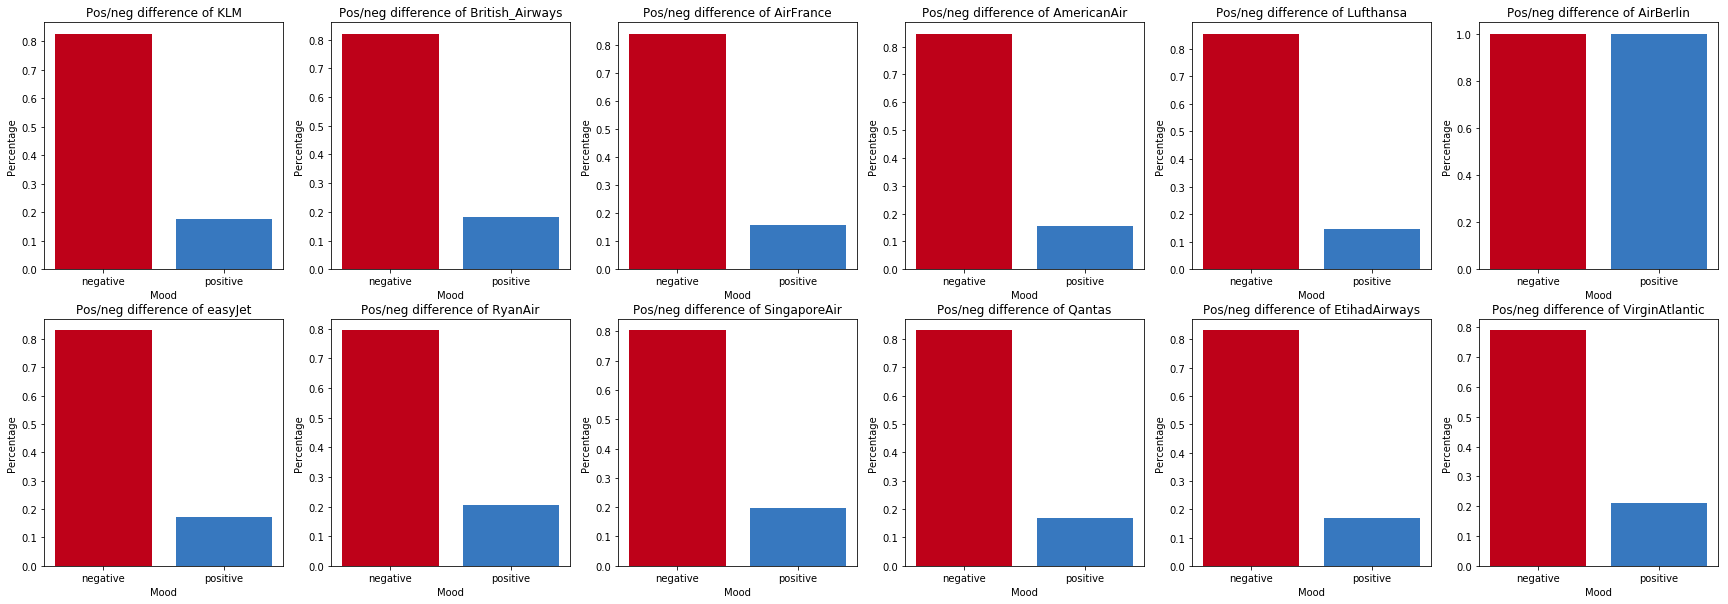

In [25]:
plt.figure(1,figsize=(30, 10))

for i in air_names2:
    indices= air_names2.index(i)
    plt.subplot(2, 6, indices+1)
    new_df=jdf[jdf['airline']==i]
    count=new_df['class'].value_counts()/len(new_df['tweet'])
    Index = [1,2]
    colorsi = ["scarlet", "windows blue"]
    plt.bar(Index, count, color=sns.xkcd_palette(colorsi))
    plt.xticks(Index,['negative','positive'])
    plt.ylabel('Percentage')
    plt.xlabel('Mood')
    plt.title('Pos/neg difference of '+i)

Another clearer visualization for the differences between airlines. 

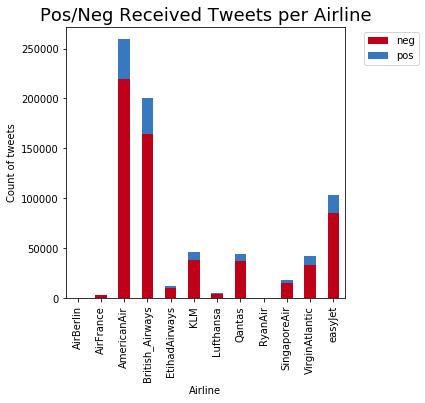

In [26]:
v1 = pd.crosstab(jdf['airline'], jdf['class']).plot(kind="bar",title='Pos/Neg Received Tweets per Airline',figsize=(5,5),stacked=True, color=sns.xkcd_palette(colorsi))
v1.title.set_size(18)
v1.set_xlabel('Airline')
v1.set_ylabel('Count of tweets')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

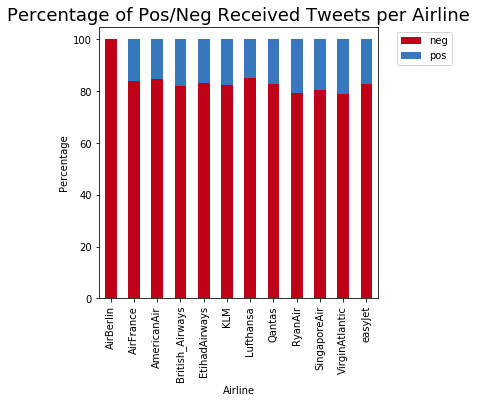

In [27]:
v2 = pd.crosstab(jdf['airline'], jdf['class']).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',title='Percentage of Pos/Neg Received Tweets per Airline',figsize=(5,5),stacked=True, color=sns.xkcd_palette(colorsi))
v2.title.set_size(18)
v2.set_xlabel('Airline')
v2.set_ylabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

In [28]:
with open('conversations.json', 'r') as convo_json:
    convos = json.load(convo_json)

In [ ]:
convos

In [ ]:
kf = pd.DataFrame()
kf['tweet'] = [t['text'] for t in tweets.find({'language':'eng', 'in_reply_to_user_id' :{'$gt': 1}}) if t['user']['id'] == airlines['KLM']]
kf['id'] = [t['id'] for t in tweets.find({'language':'eng','in_reply_to_user_id' :{'$gt': 1}}) if t['user']['id'] == airlines['KLM'] ]
kf['replied to'] = [t['in_reply_to_status_id'] for t in tweets.find({'language':'eng','in_reply_to_user_id' :{'$gt': 1}}) if t['user']['id'] == airlines['KLM']]

In [ ]:
kf = kf.convert_dtypes()
kf

In [ ]:
for i in jdf['id']:
    for j in kf['replied to']:
        if i == int(j):
            print(jdf['tweet'])

In [ ]:
for n in convos:
    for i in convos[n]['convs']:
        print(i)

In [ ]:
l = []
for i in jdf['id']:
    for key in convos:
        if i == key:
            print(i)
#l